In [1]:
import os
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import ResNet50, MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np

In [2]:
base_dir = '/kaggle/input/egyptian-hieroglyphs'
writable_base_dir = '/kaggle/working'
datasets = ['train', 'valid', 'test']

In [3]:
for dataset in datasets:
    data_dir = os.path.join(base_dir, dataset)
    organized_dir = os.path.join(writable_base_dir, f'organized_{dataset}')
    os.makedirs(organized_dir, exist_ok=True)
    
    for filename in os.listdir(data_dir):
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            class_name = filename.split('-')[0]
            class_dir = os.path.join(organized_dir, class_name)
            os.makedirs(class_dir, exist_ok=True)
            src = os.path.join(data_dir, filename)
            dst = os.path.join(class_dir, filename)
            shutil.copy(src, dst)

print("Images reorganized.")

Images reorganized.


In [4]:
train_dir = os.path.join(writable_base_dir, 'organized_train')
valid_dir = os.path.join(writable_base_dir, 'organized_valid')
test_dir = os.path.join(writable_base_dir, 'organized_test')

# Data generators
datagen = ImageDataGenerator(rescale=1./255)
train_generator = datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=True)
valid_generator = datagen.flow_from_directory(valid_dir, target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=False)
test_generator = datagen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=False)

num_classes = train_generator.num_classes
input_shape = (224, 224, 3)

Found 2723 images belonging to 92 classes.
Found 778 images belonging to 92 classes.
Found 389 images belonging to 91 classes.


In [7]:
callbacks = [
    EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True),
    ModelCheckpoint('best_model.keras', save_best_only=True)
]

In [8]:
def build_simple_cnn(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

# Step 2: Transfer Learning Models
def build_transfer_model(base_model, num_classes):
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [9]:
cnn_model = build_simple_cnn(input_shape, num_classes)
resnet_model = build_transfer_model(ResNet50(weights='imagenet', include_top=False, input_shape=input_shape), num_classes)
mobilenet_model = build_transfer_model(MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape), num_classes)

# Train and evaluate models
models = {
    "CNN": cnn_model,
    "ResNet50": resnet_model,
    "MobileNetV2": mobilenet_model
}

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
results = []
for model_name, model in models.items():
    print(f"Training {model_name}...")
    history = model.fit(train_generator, validation_data=valid_generator, epochs=20, callbacks=callbacks)
    
    # Train set evaluation
    y_train_true = train_generator.classes
    y_train_pred = np.argmax(model.predict(train_generator), axis=1)
    report_train = classification_report(y_train_true, y_train_pred, output_dict=True, zero_division=0)
    
    # Test set evaluation
    y_test_true = test_generator.classes
    y_test_pred = np.argmax(model.predict(test_generator), axis=1)
    report_test = classification_report(y_test_true, y_test_pred, output_dict=True, zero_division=0)
    
    results.append({
        "Model": model_name,
        "Accuracy Train": report_train['accuracy'],
        "Accuracy Test": report_test['accuracy'],
        "Precision Train": report_train['weighted avg']['precision'],
        "Precision Test": report_test['weighted avg']['precision'],
        "Recall Train": report_train['weighted avg']['recall'],
        "Recall Test": report_test['weighted avg']['recall'],
        "F1-score Train": report_train['weighted avg']['f1-score'],
        "F1-score Test": report_test['weighted avg']['f1-score']
    })

Training CNN...
Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1729950461.268115     124 service.cc:145] XLA service 0x7da9bc008290 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729950461.268166     124 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 3/86 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.0000e+00 - loss: 15.6979

I0000 00:00:1729950467.690603     124 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


86/86 ━━━━━━━━━━━━━━━━━━━━ 23s 155ms/step - accuracy: 0.0107 - loss: 13.0903 - val_accuracy: 0.0206 - val_loss: 4.5219
Epoch 2/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - accuracy: 0.0430 - loss: 5.3861 - val_accuracy: 0.0206 - val_loss: 4.5225
Epoch 3/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - accuracy: 0.0319 - loss: 4.7631 - val_accuracy: 0.0206 - val_loss: 4.5228
Epoch 4/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - accuracy: 0.0344 - loss: 4.6093 - val_accuracy: 0.0206 - val_loss: 4.5234
Epoch 5/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step - accuracy: 0.0397 - loss: 4.5778 - val_accuracy: 0.0206 - val_loss: 4.5244
Epoch 6/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step - accuracy: 0.0361 - loss: 4.5515 - val_accuracy: 0.0206 - val_loss: 4.5373
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step
Training ResNet50...
Epoch 1/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 29s 194ms/step - accuracy: 0.0123 - loss: 4.6765 - val_accuracy: 0.0206 - val_loss: 4.5223
Epoch 2/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - accuracy: 0.0275 - loss: 4.5203 - val_accuracy: 0.0206 - val_loss: 4.5225
Epoch 3/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - accuracy: 0.0394 - loss: 4.5173 - val_accuracy: 0.0206 - val_loss: 4.5229
Epoch 4/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 8s 86ms/step - accuracy: 0.0422 - loss: 4.5153 - val_accuracy: 0.0206 - val_loss: 4.5233
Epoch 5/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - accuracy: 0.0330 - loss: 4.5153 - val_accuracy: 0.0206 - val_loss: 4.5239
86/86 ━━━━━━━━━━━━━━━━━━━━ 12s 99ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 222ms/step
Training MobileNetV2...
Epoch 1/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 26s 184ms/step - accuracy: 0.0809 - loss: 4.2642 - val_accuracy: 0.5746 - val_loss: 2.3239
Epoch 2/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - accuracy: 0.4

In [16]:
df_results = pd.DataFrame(results)
df_results

,Model,Accuracy Train,Accuracy Test,Precision Train,Precision Test,Recall Train,Recall Test,F1-score Train,F1-score Test
0,CNN,0.033419,0.012853,0.001117,0.000165,0.033419,0.012853,0.002161,0.000326
1,ResNet50,0.032317,0.012853,0.001117,0.000168,0.032317,0.012853,0.002159,0.000331
2,MobileNetV2,0.007712,0.562982,0.007739,0.556769,0.007712,0.562982,0.007725,0.558299


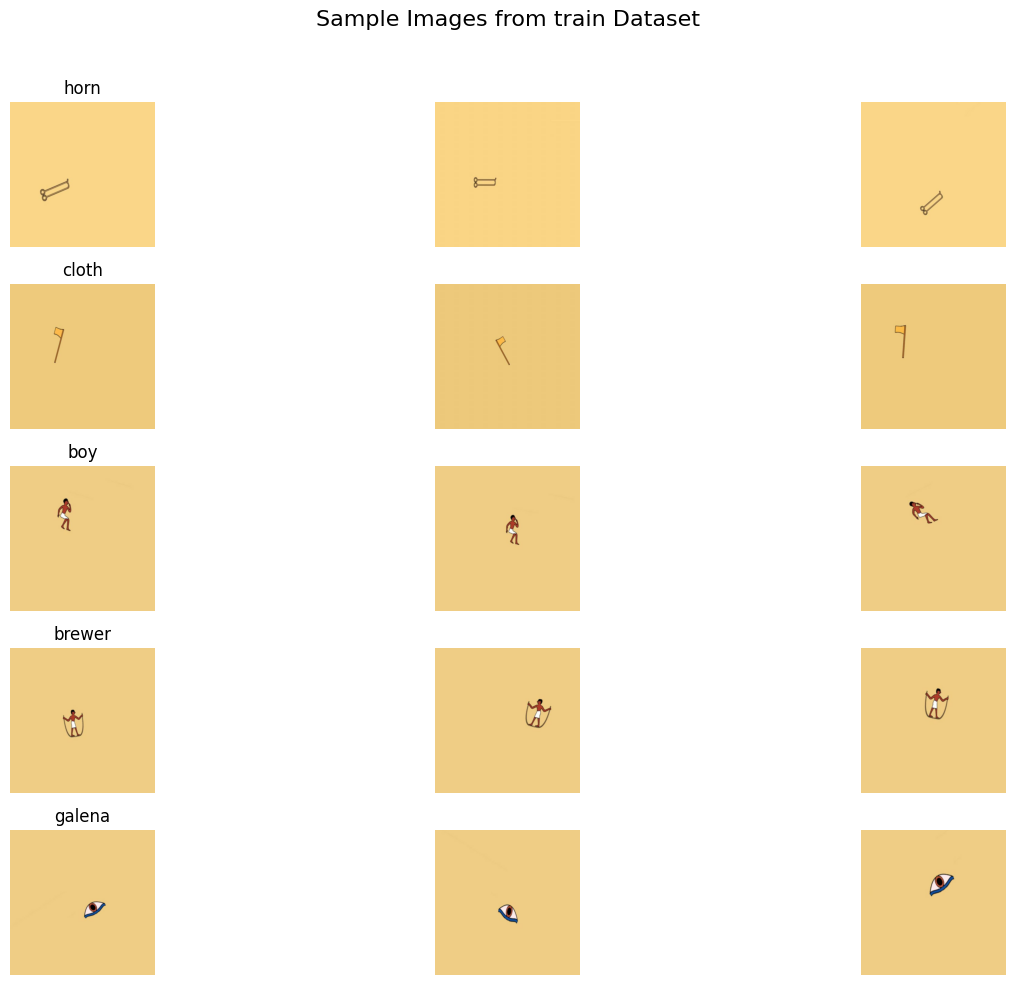

In [13]:
import os
import random
import matplotlib.pyplot as plt
import cv2


test_dir = '/kaggle/working/organized_train'


num_classes_to_display = 5 
num_images_per_class = 3


classes = os.listdir(test_dir)
random.shuffle(classes)  

# Create a figure to hold our subplots
fig, axes = plt.subplots(num_classes_to_display, num_images_per_class, figsize=(15, 10))
fig.suptitle("Sample Images from train Dataset", fontsize=16)


for i, class_name in enumerate(classes[:num_classes_to_display]):

    class_dir = os.path.join(test_dir, class_name)
    

    images = os.listdir(class_dir)
    random_images = random.sample(images, min(len(images), num_images_per_class))
    
    
    for j, image_name in enumerate(random_images):
        
        image_path = os.path.join(class_dir, image_name)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  
        
        
        axes[i, j].imshow(image)
        axes[i, j].axis('off')
        if j == 0:
            axes[i, j].set_title(class_name)  

plt.tight_layout(rect=[0, 0, 1, 0.96])  
plt.show()


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_results(results):
  
    results_df = pd.DataFrame(results)

    
    bar_width = 0.2
    x = np.arange(len(results_df['Model']))

  
    fig, ax = plt.subplots(2, 1, figsize=(12, 10))

    
    ax[0].bar(x - bar_width/2, results_df['Accuracy Train'], width=bar_width, label='Train Accuracy')
    ax[0].bar(x + bar_width/2, results_df['Accuracy Test'], width=bar_width, label='Test Accuracy')
    ax[0].set_xticks(x)
    ax[0].set_xticklabels(results_df['Model'])
    ax[0].set_ylabel('Accuracy')
    ax[0].set_title('Model Accuracy Comparison')
    ax[0].legend()

  
    ax[1].bar(x - bar_width/2, results_df['F1-score Train'], width=bar_width, label='Train F1-Score')
    ax[1].bar(x + bar_width/2, results_df['F1-score Test'], width=bar_width, label='Test F1-Score')
    ax[1].set_xticks(x)
    ax[1].set_xticklabels(results_df['Model'])
    ax[1].set_ylabel('F1-Score')
    ax[1].set_title('Model F1-Score Comparison')
    ax[1].legend()

    plt.tight_layout()
    plt.show()


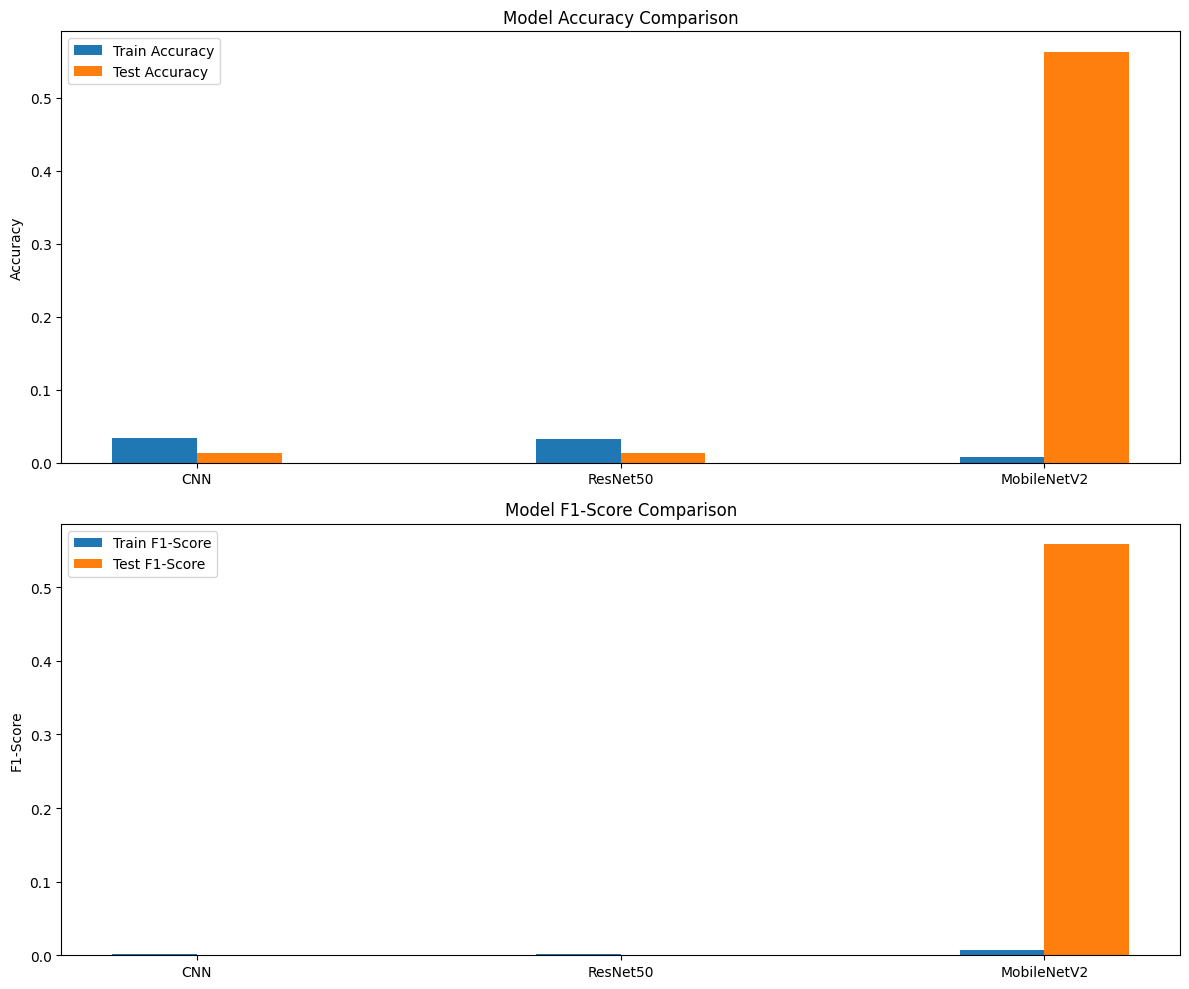

In [18]:
plot_results(results)

In [20]:
from tensorflow.keras.applications import  InceptionV3, DenseNet121
inception_model = build_transfer_model(InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape), num_classes)
densenet_model = build_transfer_model(DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape), num_classes)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [22]:
models = {
    
    "InceptionV3": inception_model,
    "DenseNet121": densenet_model
}

result = []
for model_name, model in models.items():
    print(f"Training {model_name}...")
    history = model.fit(train_generator, validation_data=valid_generator, epochs=20, callbacks=callbacks)
    
    # Train set evaluation
    y_train_true = train_generator.classes
    y_train_pred = np.argmax(model.predict(train_generator), axis=1)
    report_train = classification_report(y_train_true, y_train_pred, output_dict=True, zero_division=0)
    

    y_test_true = test_generator.classes
    y_test_pred = np.argmax(model.predict(test_generator), axis=1)
    report_test = classification_report(y_test_true, y_test_pred, output_dict=True, zero_division=0)
    
    result.append({
        "Model": model_name,
        "Accuracy Train": report_train['accuracy'],
        "Accuracy Test": report_test['accuracy'],
        "Precision Train": report_train['weighted avg']['precision'],
        "Precision Test": report_test['weighted avg']['precision'],
        "Recall Train": report_train['weighted avg']['recall'],
        "Recall Test": report_test['weighted avg']['recall'],
        "F1-score Train": report_train['weighted avg']['f1-score'],
        "F1-score Test": report_test['weighted avg']['f1-score']
    })

Training InceptionV3...
Epoch 1/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - accuracy: 0.3183 - loss: 2.8182 - val_accuracy: 0.8111 - val_loss: 1.4304
Epoch 2/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 8s 86ms/step - accuracy: 0.5467 - loss: 1.7787 - val_accuracy: 0.8920 - val_loss: 0.7751
Epoch 3/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - accuracy: 0.6589 - loss: 1.2779 - val_accuracy: 0.9293 - val_loss: 0.4322
Epoch 4/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - accuracy: 0.7379 - loss: 0.9568 - val_accuracy: 0.9512 - val_loss: 0.2959
Epoch 5/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - accuracy: 0.7807 - loss: 0.8032 - val_accuracy: 0.9460 - val_loss: 0.2412
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
Training DenseNet121...
Epoch 1/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 61s 407ms/step - accuracy: 0.0769 - loss: 4.2469 - val_accuracy: 0.5501 - val_loss: 2.6006
Epoch 2/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - accuracy: 0.4355 - loss: 2.4173 - val_accuracy: 0.8753

In [23]:
df_result = pd.DataFrame(result)
df_result

,Model,Accuracy Train,Accuracy Test,Precision Train,Precision Test,Recall Train,Recall Test,F1-score Train,F1-score Test
0,InceptionV3,0.011017,0.452442,0.009115,0.451781,0.011017,0.452442,0.009847,0.442496
1,DenseNet121,0.013955,0.298201,0.010138,0.358962,0.013955,0.298201,0.010644,0.293343


In [ ]:
##################################################################################################################################
#######################################################################################################
##############################################################################################

In [ ]:
#aftercropping the image for better accuracies
####################################################################3

In [25]:
base_dir = '/kaggle/input/egyptian-hieroglyphs'
writable_base_dir = '/kaggle/working'
datasets = ['train', 'valid', 'test']

for dataset in datasets:
    data_dir = os.path.join(base_dir, dataset)
    organized_dir = os.path.join(writable_base_dir, f'organized_{dataset}')
    os.makedirs(organized_dir, exist_ok=True)
    
    for filename in os.listdir(data_dir):
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            class_name = filename.split('-')[0]
            class_dir = os.path.join(organized_dir, class_name)
            os.makedirs(class_dir, exist_ok=True)
            src = os.path.join(data_dir, filename)
            dst = os.path.join(class_dir, filename)
            shutil.copy(src, dst)

print("images reorganized.")


train_dir = os.path.join(writable_base_dir, 'organized_train')
valid_dir = os.path.join(writable_base_dir, 'organized_valid')
test_dir = os.path.join(writable_base_dir, 'organized_test')


def crop_and_resize(img, target_size=(224, 224), crop_fraction=0.8):
    height, width = img.shape[0], img.shape[1]
    crop_height, crop_width = int(height * crop_fraction), int(width * crop_fraction)
    img = tf.image.resize_with_crop_or_pad(img, crop_height, crop_width)
    img = tf.image.resize(img, target_size)
    return img

# Data generators with cropping
datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=lambda img: crop_and_resize(img, target_size=(224, 224), crop_fraction=0.8)
)

train_generator = datagen.flow_from_directory(
    train_dir, target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=True
)
valid_generator = datagen.flow_from_directory(
    valid_dir, target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=False
)
test_generator = datagen.flow_from_directory(
    test_dir, target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=False
)


num_classes = train_generator.num_classes
input_shape = (224, 224, 3)

Images reorganized.
Found 2723 images belonging to 92 classes.
Found 778 images belonging to 92 classes.
Found 389 images belonging to 91 classes.


In [26]:
models = {
    
    "InceptionV3": inception_model,
    "DenseNet121": densenet_model
}

result = []
for model_name, model in models.items():
    print(f"Training {model_name}...")
    history = model.fit(train_generator, validation_data=valid_generator, epochs=20, callbacks=callbacks)
    
    # Train set evaluation
    y_train_true = train_generator.classes
    y_train_pred = np.argmax(model.predict(train_generator), axis=1)
    report_train = classification_report(y_train_true, y_train_pred, output_dict=True, zero_division=0)
    

    y_test_true = test_generator.classes
    y_test_pred = np.argmax(model.predict(test_generator), axis=1)
    report_test = classification_report(y_test_true, y_test_pred, output_dict=True, zero_division=0)
    
    result.append({
        "Model": model_name,
        "Accuracy Train": report_train['accuracy'],
        "Accuracy Test": report_test['accuracy'],
        "Precision Train": report_train['weighted avg']['precision'],
        "Precision Test": report_test['weighted avg']['precision'],
        "Recall Train": report_train['weighted avg']['recall'],
        "Recall Test": report_test['weighted avg']['recall'],
        "F1-score Train": report_train['weighted avg']['f1-score'],
        "F1-score Test": report_test['weighted avg']['f1-score']
    })

Training InceptionV3...
Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


86/86 ━━━━━━━━━━━━━━━━━━━━ 23s 257ms/step - accuracy: 0.4521 - loss: 2.1102 - val_accuracy: 0.8856 - val_loss: 0.8555
Epoch 2/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 23s 259ms/step - accuracy: 0.6302 - loss: 1.3909 - val_accuracy: 0.9229 - val_loss: 0.5420
Epoch 3/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 23s 252ms/step - accuracy: 0.6971 - loss: 1.1050 - val_accuracy: 0.9409 - val_loss: 0.3625
Epoch 4/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 23s 251ms/step - accuracy: 0.7451 - loss: 0.8893 - val_accuracy: 0.9409 - val_loss: 0.2621
Epoch 5/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 24s 263ms/step - accuracy: 0.7849 - loss: 0.7509 - val_accuracy: 0.9499 - val_loss: 0.2624
86/86 ━━━━━━━━━━━━━━━━━━━━ 18s 207ms/step
 1/13 ━━━━━━━━━━━━━━━━━━━━ 2s 209ms/step

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 194ms/step
Training DenseNet121...
Epoch 1/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 24s 261ms/step - accuracy: 0.3743 - loss: 2.6980 - val_accuracy: 0.8355 - val_loss: 1.3225
Epoch 2/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 22s 247ms/step - accuracy: 0.6434 - loss: 1.5131 - val_accuracy: 0.9293 - val_loss: 0.6980
Epoch 3/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 23s 249ms/step - accuracy: 0.7694 - loss: 1.0267 - val_accuracy: 0.9293 - val_loss: 0.4392
Epoch 4/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 23s 250ms/step - accuracy: 0.8308 - loss: 0.7323 - val_accuracy: 0.9422 - val_loss: 0.3027
Epoch 5/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 23s 256ms/step - accuracy: 0.8629 - loss: 0.5637 - val_accuracy: 0.9447 - val_loss: 0.2376
86/86 ━━━━━━━━━━━━━━━━━━━━ 18s 204ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 188ms/step


In [27]:
df_result = pd.DataFrame(result)
df_result

,Model,Accuracy Train,Accuracy Test,Precision Train,Precision Test,Recall Train,Recall Test,F1-score Train,F1-score Test
0,InceptionV3,0.011385,0.496144,0.011209,0.533890,0.011385,0.496144,0.011258,0.501339
1,DenseNet121,0.010650,0.508997,0.009097,0.506578,0.010650,0.508997,0.009696,0.498029
